# Corso di Identificazione dei Modelli e Analisi dei Dati (IMAD) A.A. 2018/2019
## **Università degli Studi di Bergamo**

## =======================  Esercitazione 1: Regressione =======================
**Autori**: Mirko Mazzoleni, Gabriele Maroni


## Import librerie

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
from ipywidgets import interact, interactive
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, GridSearchCV
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns


## Creazione del dataset

In [2]:
def true_function(x):
    return 0.0002*x**5 -0.0111*x**4 -0.1282*x**3 -0.2507*x**2 +0.4657*x + 5.2726 + np.sin(2*x) #define a function 

def create_data(n_samples, noise):
    x = np.linspace(-6, 2, n_samples) #generate input
    f = true_function(x) # generate output
    y = f + noise*np.random.randn(n_samples) # add noise on observed data y
    data = np.zeros((n_samples,3)) # initialize dataset
    data[:, 0] = x # inputs
    data[:, 1] = y # noisy outputs
    data[:, 2] = f # true (noiseless) outputs
    #norm = StandardScaler()
    return data #norm.fit_transform(data)

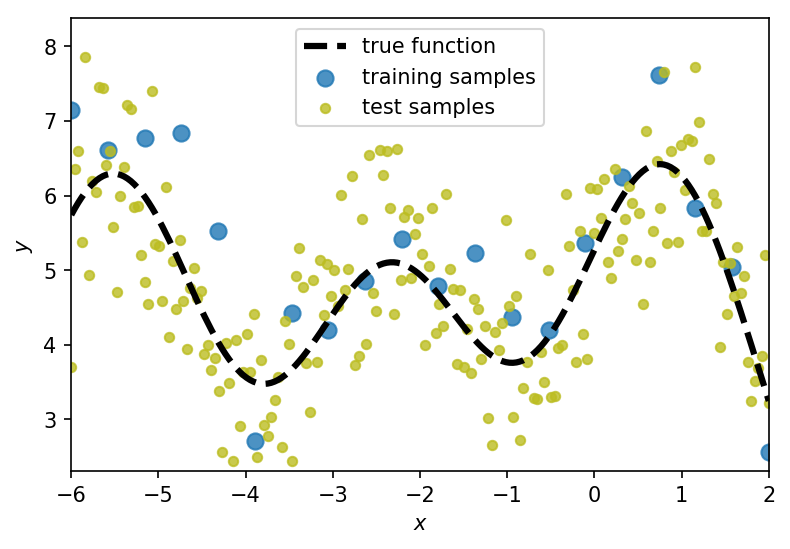

In [3]:
np.random.seed(0) # set random seed
var_noise = 0.8 # variance of noise
N = 20 # number of train data
data_train = create_data(N, var_noise) # create train data N = 30 samples, 10 = variance noise
x_train = data_train[:,0][:, np.newaxis] # get input data and make a Nx1 matrix
y_train = data_train[:,1] # output train
f = data_train[:,2] # noiseless outputs

Nt = 200 # number of test data
data_test = create_data(Nt, var_noise) # create test data Nt = 20
x_test = data_test[:,0][:, np.newaxis] # get input data and make a Ntx1 matrix
y_test = data_test[:,1]

Np = 200 # number of data, only for plotting purposes
data_plot = create_data(Np, 0) 
x_plot = data_plot[:,0][:, np.newaxis] 
y_plot = data_plot[:,1]


fig=plt.figure(figsize=(6, 4), dpi= 150, facecolor='w', edgecolor='k')
plt.plot(x_plot, y_plot, 'k--', alpha=1, label='true function', linewidth = 3)
plt.scatter(x_train, y_train, label='training samples', color='C0', s=60, alpha=0.8)
plt.scatter(x_test, y_test, label='test samples', color='C8', s=20, alpha=0.8)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.ylim(np.min(y_train)*0.9, np.max(y_train)*1.1); plt.xlim(np.min(x_train), np.max(x_train)); 
plt.legend(frameon=True, loc = 'best');


## Creazione del modello di predizione

I dati provengono da un modello non lineare, un metodo semplice per creare un modello in grado di fare predizioni non lineari è quello di utilizzare features polinomiali.

Ma quale è il grado delle features polinomiali che meglio approssima la funzione vera?

In [4]:
def make_features(data_set, degrees): # create polynomial features from data
    data_dict = {}
    for d in degrees: # each element of the dictionary contains a data matrix X with d polynomial features 
        data_dict[d] = PolynomialFeatures(d).fit_transform(data_set) # create polyonmial features of degree d
    return data_dict

In [5]:
scaler = StandardScaler() # use to standardize the data
max_degree = N - 1; # max degree of polynomial
degrees = range(max_degree + 1) # degrees from 0 to 30
train_dict = make_features(x_train, degrees) # create features for train
test_dict = make_features(x_test, degrees) # create features for test

In [6]:
train_dict[2][1:4]

array([[ 1.        , -5.57894737, 31.12465374],
       [ 1.        , -5.15789474, 26.60387812],
       [ 1.        , -4.73684211, 22.43767313]])

In [7]:
error_train = np.empty(len(degrees)) # initialize array error, one for each polynomial degree

for d in degrees:
    X_train = train_dict[d] # select d feeatures
    X_train_scaled = scaler.fit_transform(X_train)
    model = LinearRegression() # define linear regression model
    model.fit(X_train_scaled, y_train) # fit linear regression model
    y_hat = model.predict(X_train_scaled) # predict
    error_train[d] = mean_squared_error(y_train, y_hat) # compute mean squared error
    
bestd = np.argmin(error_train) # find order that gives lowes train error

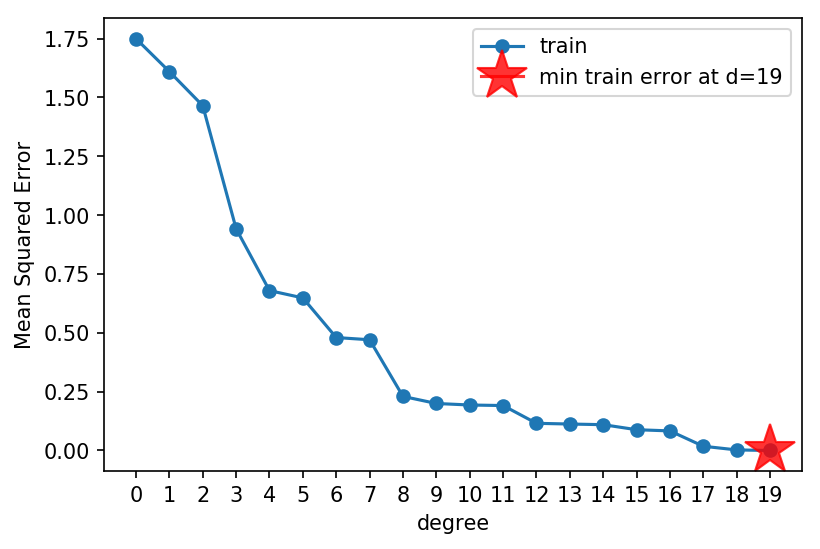

In [8]:
fig = plt.figure(figsize=(6, 4), dpi= 150, facecolor='w', edgecolor='k')
plt.plot(degrees, error_train, marker='o', label='train')
plt.plot(bestd, error_train[bestd], marker='*', markersize=25, color='r', label="min train error at d=%d"%bestd, alpha=0.8)
plt.ylabel('Mean Squared Error')
plt.xlabel('degree')
plt.legend(loc='best', frameon=True)
#plt.yscale("log")
plt.xticks(range(max_degree+1));

Che indicazioni ci da questo grafico?
- che il modello migliore in termini di errore quandratico medio sul nostro training set è il modello di grado 20

## Predizione sui dati di test

Il nostro obiettivo è quello di testare il modello allenato sui dati di train, e il cui ordine è stato scelto dall'analisi precedente, sul dataset di test. 

Dal momento che il modello performa bene sul set di train su cui è stato allenato, è ragionevole aspettarsi che questo modello performi bene anche sul set di test?

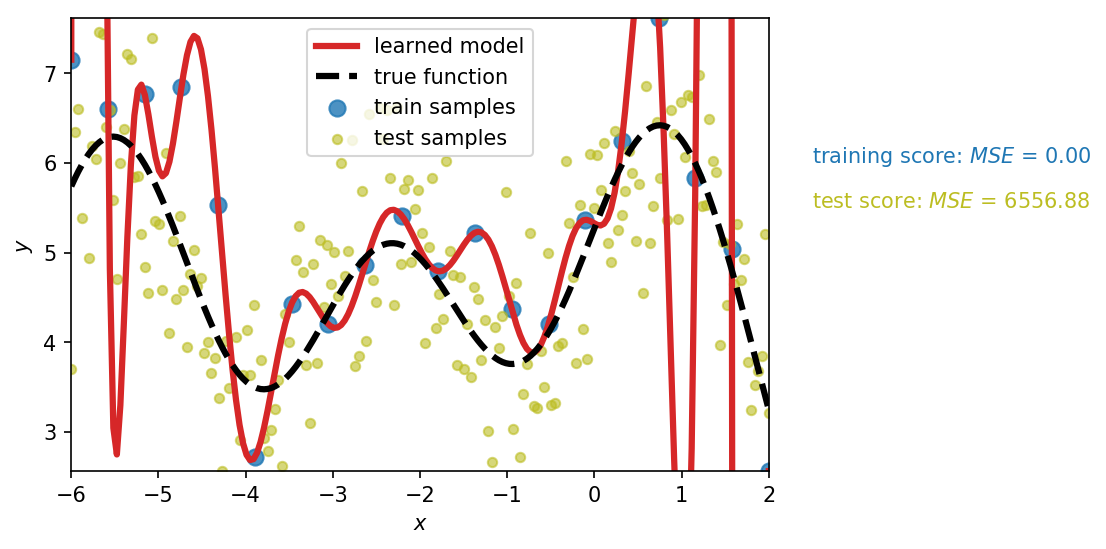

In [9]:
degree = bestd # fix best polynomial order found on the training set

X_train = train_dict[degree] # create train data matrix
X_train_scaled = scaler.fit_transform(X_train) # scale
model = LinearRegression() # define linear regression model
model.fit(X_train_scaled, y_train) # fit linear regression model

X_test = test_dict[degree] # create test data matrix
X_test_scaled = scaler.transform(X_test) # scale with information obtained from train data

plot_dict = make_features(x_plot, [degree])
X_plot = plot_dict[degree]
X_plot_scaled = scaler.transform(X_plot)

fig = plt.figure(figsize=(6, 4), dpi= 150, facecolor='w', edgecolor='k')
plt.plot(x_plot, model.predict(X_plot_scaled), linestyle='-', label='learned model', color='C3', linewidth=3)
plt.scatter(x_train, y_train, alpha=0.8, label='train samples', color='C0', s=60)
plt.scatter(x_test, y_test, alpha=0.6, label='test samples', color='C8', s=20)
plt.plot(x_plot, y_plot, 'k--',alpha=1, label='true function', linewidth=3)
plt.ylim(np.min(y_train), np.max(y_train)); plt.xlim(np.min(x_train), np.max(x_train))
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.text(2.5, 6, "training score: $MSE$ = {0:.2f}".format(mean_squared_error(y_train, model.predict(X_train_scaled))),
         color='C0')
plt.text(2.5, 5.5,"test score: $MSE$ = {0:.2f}".format(mean_squared_error(y_test, model.predict(X_test_scaled))), color='C8')
plt.legend(loc='best', frameon=True);

In [10]:
train_error1 = mean_squared_error(y_train, model.predict(X_train_scaled))
test_error1 = mean_squared_error(y_test, model.predict(X_test_scaled))
print('Train error:', train_error1)
print('Test error:', test_error1)

Train error: 2.668332632181309e-11
Test error: 6556.882587448362


L'errore di test è molto superiore rispetto all'errore di train, come mai si discostano così tanto?

Cerchiamo di capire, tramite un'analisi grafica di sensitività, come variano errore di train ed errore di test al variare dell'ordine del modello.

In [11]:
r = (1, max_degree)

def plot_poly(degree = 1):
    
    X_train = train_dict[degree] # select d feeatures
    X_train_scaled = scaler.fit_transform(X_train)
    model = LinearRegression() # define linear regression model
    model.fit(X_train_scaled, y_train) # fit linear regression model

    
    X_test = test_dict[degree] # select d feeatures
    X_test_scaled = scaler.transform(X_test)
    
    
    xx = np.linspace(-6, 2, 200)[:, np.newaxis]
    plot_dict = make_features(xx, [degree])
    X_plot = plot_dict[degree]
    X_plot_scaled = scaler.transform(X_plot)
    
        
    fig = plt.figure(figsize=(6, 4), dpi= 150, facecolor='w', edgecolor='k')
    plt.plot(xx, model.predict(X_plot_scaled), linestyle='-', label="learned model", linewidth=3, color='C3')
    plt.plot(x_plot, y_plot, 'k--',alpha=1, label="true function", linewidth=3)
    plt.scatter(x_train, y_train, alpha=0.6, label="train samples", color='C0', s=60)
    plt.scatter(x_test, y_test, alpha=0.6, label="test samples", color='C8', s=20)
    plt.xlabel("$x$"); plt.ylabel("$y$")
    plt.ylim(np.min(y_train)*0.9, np.max(y_train)*1.1);  plt.xlim(np.min(x_train), np.max(x_train))
    plt.legend(loc='best', frameon=True)
    plt.text(2.5, 6, "training score: $MSE$ = {0:.2f}".format(mean_squared_error(y_train, model.predict(X_train_scaled))),
         color='C0')
    plt.text(2.5, 5.5, "test score: $MSE$ = {0:.2f}".format(mean_squared_error(y_test, model.predict(X_test_scaled))), color='C8')
    plt.show()
    
w=interactive(plot_poly, degree=r)
w

interactive(children=(IntSlider(value=1, description='degree', max=19, min=1), Output()), _dom_classes=('widge…

Osservazioni dal grafico interattivo:

- i modelli di ordine basso (ordini 1 e 2) non sono in grado di approssimare in maniera sufficientemente accurata la forma del modello vero da cui sono stati generati i dati. Si osserva che l'errore di train e l'errore di test sono simili come valori ed entrambi relativamente alti. Si dice che questi modelli soffrano di **bias elevato** o anche di **underfitting**;


- il modello di ordine 3 è in grado di approssimare in maniera accurata la funzione vera, ciò è ragionevole dal momento che il modello vero è appunto una funzione di grado 3. In questa situazione i valori degli errori di train e di test sono simili ed entrambi bassi;


- Mano a mano che l'ordine si alza, si osserva che i modelli allenati hanno delle forme sempre più complesse. Questi modelli, oltre ad imparare la forma della funzione vera, tendono ad imparare anche il rumore contenuto nello specifico training set su cui sono allenati. Si osserva che errore di train ed errore di test appaiono molto differenti, in particolare l'errore di train tende a decrescere con l'aumentare dell'ordine del modello. Al contrario l'errore di test tende ad aumentare in maniera molto elevata all'aumentare dell'ordine del modello. Si dice che questi modelli soffrano di **varianza elevata** o anche di **overfitting**.

## Calcolo degli errori di test di un modello che soffre di bias elevato e di un modello che soffre di varianza elevata

### High variance

In [12]:
X_train = train_dict[max_degree] # select d feeatures
X_train_scaled = scaler.fit_transform(X_train)
model = LinearRegression() # define linear regression model
model.fit(X_train_scaled, y_train) # fit linear regression model

X_test = test_dict[max_degree] # select d feeatures
X_test_scaled = scaler.transform(X_test)

test_error2 = mean_squared_error(y_test, model.predict(X_test_scaled))
test_error2

6556.882587448362

### High bias

In [13]:
X_train = train_dict[1] # select d feeatures
X_train_scaled = scaler.fit_transform(X_train)
model = LinearRegression() # define linear regression model
model.fit(X_train_scaled, y_train) # fit linear regression model

X_test = test_dict[1] # select d feeat
X_test_scaled = scaler.transform(X_test)

test_error3 = mean_squared_error(y_test, model.predict(X_test_scaled))
test_error3

1.7656493448578021

## Valutazione di un modello tramite le curve di apprendimento

Un metodo utile per valutare le performances di un modello in termini di bias/varianza è quello di plottare le curve di apprendimento, esse illustrano il processo di apprendimento al variare del numero dei campioni del training set.
Quando un dataset è piccolo, è facile che un modello complesso lo fitti con precisione rischiando però di fare overfitting. Mano a mano che il dataset cresce è ragionevole aspettarsi che l'errore di train aumenti. Al contrario, con un dataset piccolo è facile che il modello allenato su di esso non generalizzi bene su dati nuovi e di conseguenza l'errore di test sarà elevato. Mano a mano che il dataset cresce ci si aspetta che il modello generalizzi meglio e che quindi l'errore di test diminuisca.
Ci forniscono, inoltre, indicazioni empiriche molto utili sul numero di dati di train che dovremmo utilizzare per allenare il modello fissato un ordine tenendo sotto controllo underfitting e overfitting.

In [14]:
def plot_learning_curves(X, y):
    np.random.seed(0) # set seed
    X_train_curv, X_test_curv, y_train_curv, y_test_curv = train_test_split(X, y, test_size=0.2) # generate train (80% of data) and test (20% of data)
    train_errors, test_errors = [], [] # init errors
    
    scaler = StandardScaler()
    X_train_curv_scaled = scaler.fit_transform(X_train_curv)
    X_test_curv_scaled = scaler.transform(X_test_curv)    
    model = LinearRegression()
    N = len(X_train_curv_scaled)
    for m in range(1, N): # consider different sizes of training data
        model.fit(X_train_curv_scaled[:m], y_train_curv[:m]) # fit linear regressions
        y_train_predict = model.predict(X_train_curv_scaled[:m]) # predict on train
        y_test_predict = model.predict(X_test_curv_scaled) # predict on validation set
        train_errors.append(mean_squared_error(y_train_predict, y_train_curv[:m])) # compute train error
        test_errors.append(mean_squared_error(y_test_predict, y_test_curv)) # compute test error
        
    fig=plt.figure(figsize=(6, 4), dpi= 150, facecolor='w', edgecolor='k')
    plt.plot((train_errors), "C0", linewidth=3, label = "train")
    plt.plot((test_errors), "C8", linewidth=3, label = "test")
    plt.ylim(0, 5); plt.xlim([0, N])
    plt.xlabel('training set size')
    plt.ylabel('Mean Squared Error')
    plt.legend(frameon=True)
    plt.show()

In [15]:
r_degree = (1, max_degree) # slider
data_curv = create_data(200, 0.5)
x_train_curv = data_curv[:, 0][:, np.newaxis] # get input data and make a Nx1 matrix
y_train_curv = data_curv[:, 1] # output train
train_dict_curv = make_features(x_train_curv, range(max_degree+1))


def learning_curves(degree=1):
    X_train_curv = train_dict_curv[degree] # select d feeatures
    plot_learning_curves(X_train_curv, y_train_curv) # compute errors and plot curves

w = interactive(learning_curves, degree=r_degree)
w    

interactive(children=(IntSlider(value=1, description='degree', max=19, min=1), Output()), _dom_classes=('widge…

## Validazione

Una tecnica utilissima per combattere ovefitting e underfitting è quella utilizzare parte dei dati di train per la validazione del modello, questi dati fanno parte di un nuovo dataset che vieno chiamato **dataset di validazione**.

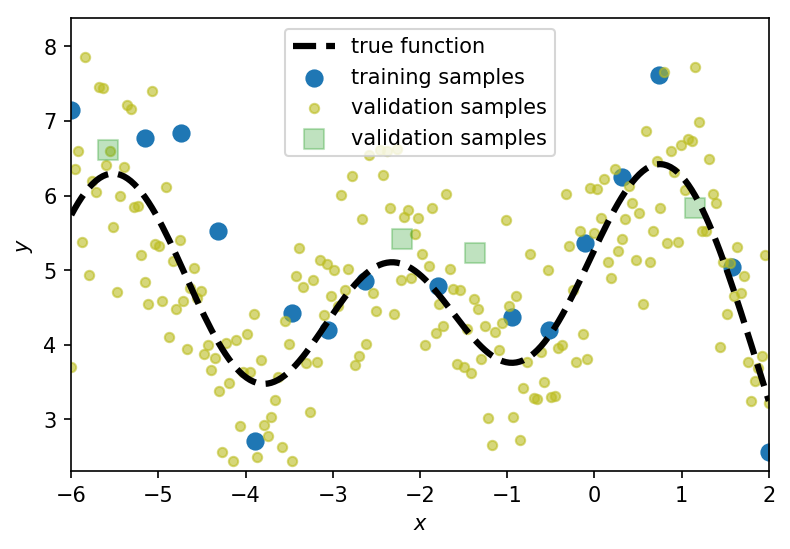

In [16]:
x_train_v, x_val_v, y_train_v, y_val_v = train_test_split(x_train, y_train, test_size=0.2) # create train and validation set


fig = plt.figure(figsize=(6, 4), dpi= 150, facecolor='w', edgecolor='k')
plt.plot(x_plot, y_plot, 'k--', alpha=1, label='true function', linewidth=3)
plt.scatter(x_train_v, y_train_v, alpha=1, label='training samples', color='C0', s=60)
plt.scatter(x_test, y_test, alpha=0.6, label='validation samples', color='C8', s=20)
plt.scatter(x_val_v, y_val_v, label='validation samples', color='C2', s=100, marker='s', alpha=0.3)
plt.xlabel('$x$'); plt.ylabel('$y$'); plt.xlim([np.min(x_train,), np.max(x_train,)]); 
plt.ylim([np.min(y_train)*0.9, np.max(y_train)*1.1])
plt.legend(frameon=True);

In [17]:
def make_features2(train_set, test_set, degrees): # create features on two different datasets
    train_dict = {}
    test_dict = {}
    for d in degrees:
        traintestdict={}
        train_dict[d] = PolynomialFeatures(d).fit_transform(train_set.reshape(-1,1))
        test_dict[d] = PolynomialFeatures(d).fit_transform(test_set.reshape(-1,1))
    return train_dict, test_dict

In [18]:
degrees = range(max_degree+1) # degrees for polynomial features
train_dict_v, val_dict_v = make_features2(x_train_v, x_val_v, degrees) # create features on train and validation set

In [19]:
error_train = np.empty(len(degrees)) # init error train
error_val = np.empty(len(degrees)) # init error validation

In [20]:
for d in degrees: # for each degree
    X_train = train_dict_v[d] # data matrix train
    X_val = val_dict_v[d] # data matrix validation
    
    X_train_scaled = scaler.fit_transform(X_train) # scale train data
    X_val_scaled = scaler.transform(X_val) # scale validation data
    
    model = LinearRegression() # define linear model
    model.fit(X_train_scaled, y_train_v) # fit linear model in train data
    y_train_hat = model.predict(X_train_scaled) # predict on train
    y_val_hat = model.predict(X_val_scaled) # predict on test
    error_train[d] = mean_squared_error(y_train_v, y_train_hat) # error train
    error_val[d] = mean_squared_error(y_val_v, y_val_hat) # error validation
    
bestd = np.argmin(error_val) # find best model on validation set
print('Best model degree: ' + str(bestd))

Best model degree: 3


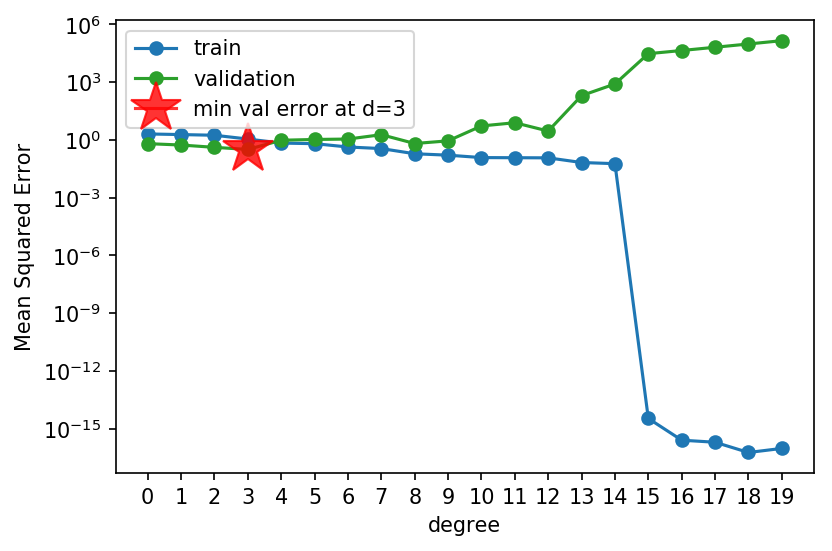

In [21]:
fig = plt.figure(figsize=(6, 4), dpi= 150, facecolor='w', edgecolor='k')
plt.plot(degrees, error_train, marker='o', label='train')
plt.plot(degrees, error_val, marker='o', label='validation',c='C2')
plt.plot(bestd, error_val[bestd], marker='*',markersize=25, color='r', label="min val error at d=%d"%bestd, alpha=0.8)
plt.ylabel('Mean Squared Error')
plt.xlabel('degree')
plt.legend(loc='best', frameon=True)
plt.yscale("log")
plt.xticks(range(max_degree+1));

## Predizione con il modello migliore trovato in fase di validazione

Refitting sull'intero training set e e calcolo dell'errore di test.

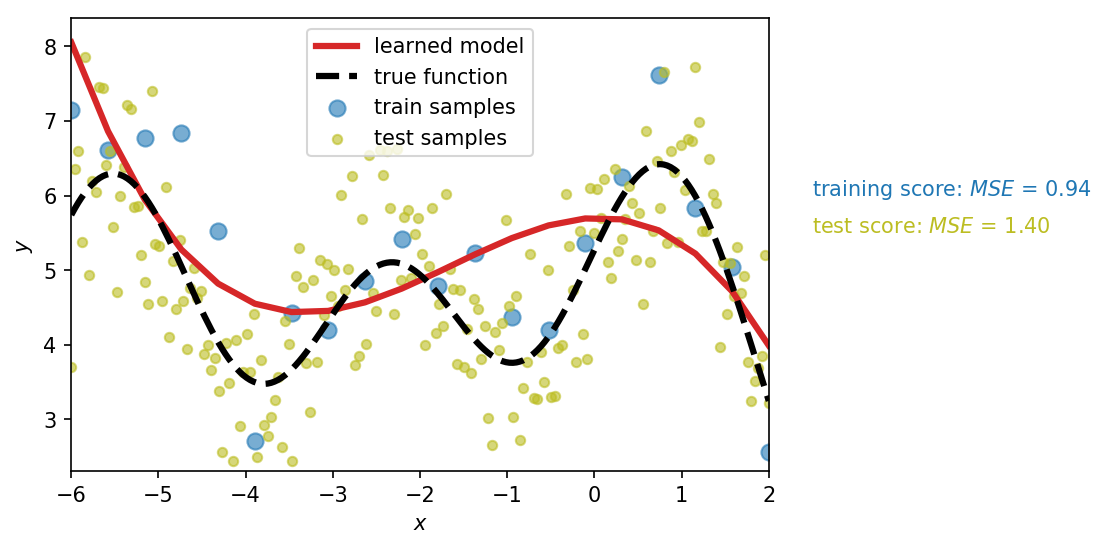

In [22]:
X_train = train_dict[bestd] # data matrix train data
X_train_scaled = scaler.fit_transform(X_train) # scale data

X_test = test_dict[bestd] # data matrix test data
X_test_scaled = scaler.transform(X_test) # scale data

model = LinearRegression() # define linear regression model
model.fit(X_train_scaled, y_train) # fit linear regression model

fig = plt.figure(figsize=(6, 4), dpi= 150, facecolor='w', edgecolor='k')
plt.plot(x_train, model.predict(X_train_scaled), linestyle='-', label="learned model", linewidth=3, color='C3')
plt.plot(x_plot, y_plot, 'k--',alpha=1, label="true function", linewidth=3)
plt.scatter(x_train, y_train, alpha=0.6, label="train samples", color='C0', s=60)
plt.scatter(x_test, y_test, alpha=0.6, label="test samples", color='C8', s=20)
plt.xlabel("$x$"); plt.ylabel("$y$")
plt.ylim(np.min(y_train)*0.9, np.max(y_train)*1.1);  plt.xlim(np.min(x_train), np.max(x_train))
plt.legend(loc='best', frameon=True)
plt.text(2.5, 6, "training score: $MSE$ = {0:.2f}".format(mean_squared_error(y_train, model.predict(X_train_scaled))),
     color='C0')
plt.text(2.5, 5.5, "test score: $MSE$ = {0:.2f}".format(mean_squared_error(y_test, model.predict(X_test_scaled))), color='C8')
plt.show()

test_error4 = mean_squared_error(y_test, model.predict(X_test_scaled)) # compute test error

High bias model: 1.7656493448578021
Validated model: 1.3967063225610457


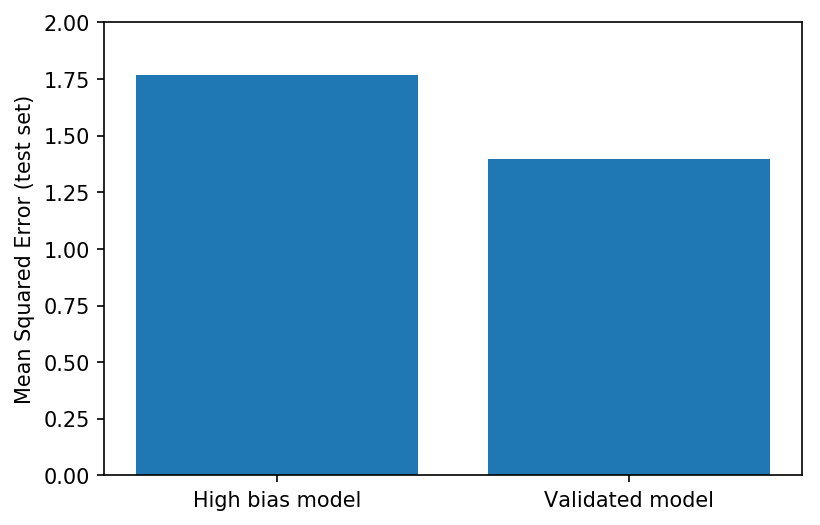

In [23]:
errors = ['High bias model', 'Validated model'] # labels for the plot

fig=plt.figure(figsize=(6, 4), dpi= 150, facecolor='w', edgecolor='k')
plt.bar([1, 2],[test_error3, test_error4], tick_label = errors)
plt.ylabel('Mean Squared Error (test set)');
plt.ylim([0, 2]);

print('High bias model:', test_error3)
print('Validated model:', test_error4)


## Cross-validazione

La cross-validazione è una tecnica utilizzabile in presenza di una buona numerosità del campione osservato o training set. In particolare la k-fold cross-validation consiste nella suddivisione del dataset totale in k parti di uguale numerosità e, ad ogni passo, la k-esima parte del dataset viene ad essere il validation dataset, mentre la restante parte costituisce il training dataset. Così, per ognuna delle k parti (di solito k = 10) si allena il modello, evitando quindi problemi di overfitting, ma anche di campionamento asimmetrico (e quindi affetto da bias) del training dataset, tipico della suddivisione del dataset in due sole parti (ovvero training e validation dataset). In altre parole, si suddivide il campione osservato in gruppi di egual numerosità, si esclude iterativamente un gruppo alla volta e lo si cerca di predire con i gruppi non esclusi. Ciò al fine di verificare la bontà del modello di predizione utilizzato.

In [24]:
n_folds = 3 # 3-fold cross validation ==> N-N/n_folds data for each training set
degrees = range(max_degree+1) 
train_errors = np.zeros((max_degree+1, n_folds)) # init train errors - for each degree and for each fold
valid_errors = np.zeros((max_degree+1, n_folds)) # init validation errors - for each degree and for each fold

In [25]:
fold = 0 
for train_idx, valid_idx in KFold(n_folds, shuffle=True).split(range(N)): # for each fold
    train_dict_cv, valid_dict_cv = make_features2(x_train[train_idx], x_train[valid_idx], degrees) # obtain indexes of data in the folds
    
    for d in degrees: # for each degree
        model = LinearRegression() # linear regression model
        X_train = train_dict_cv[d]; # data matrix train
        X_train_scaled = scaler.fit_transform(X_train) # scale train data
        
        X_valid_v = valid_dict_cv[d] # data matrix validation
        X_valid_v_scaled = scaler.transform(X_valid_v) # scale validation data
        
        model.fit(X_train_scaled, y_train[train_idx]) # fit linear model
        train_errors[d, fold] = mean_squared_error(y_train[train_idx], model.predict(X_train_scaled)) # train error
        valid_errors[d, fold] = mean_squared_error(y_train[valid_idx], model.predict(X_valid_v_scaled)) # test error
    fold += 1

In [26]:
mean_train_errors = train_errors.mean(axis=1) # mean of train errors for each degree
mean_valid_errors = valid_errors.mean(axis=1) # mean of validation errors for each degree
std_train_errors = train_errors.std(axis=1) # standard deviation of train errors for each degree 
std_valid_errors = valid_errors.std(axis=1) # standard deviation of validation errors for each degree

Best model degree: 3


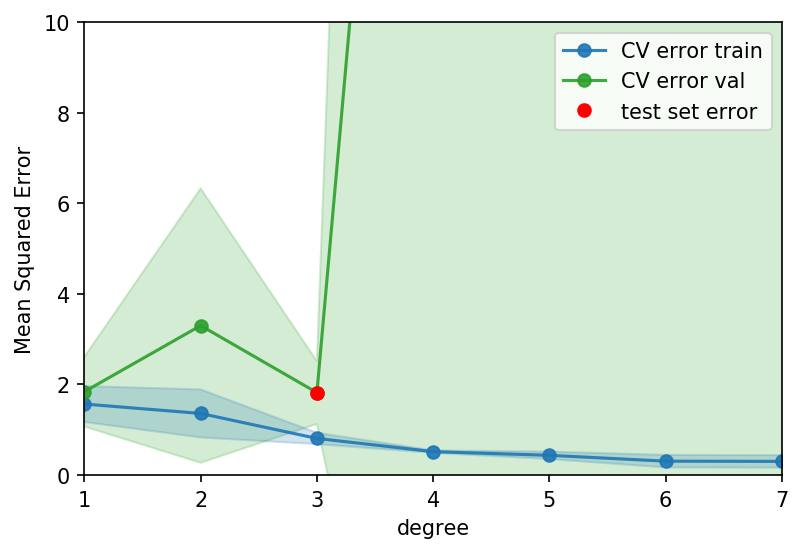

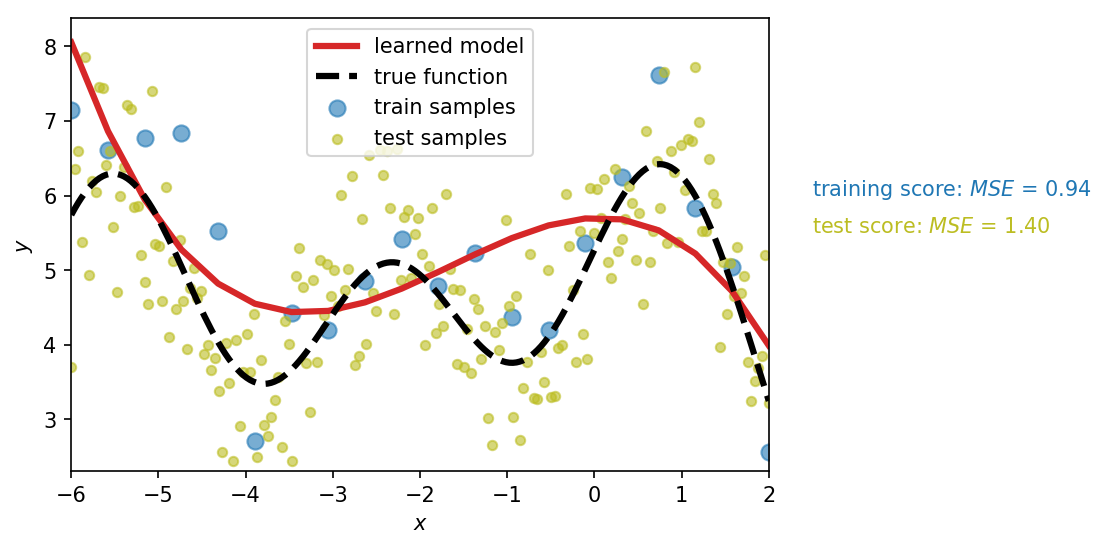

In [27]:
mindeg = np.argmin(mean_valid_errors) # find degree that gave smallest cross-validation error
print('Best model degree: ' + str(mindeg))

X_train = train_dict[mindeg]
X_train_scaled = scaler.fit_transform(X_train)

X_test = test_dict[mindeg]
X_test_scaled = scaler.transform(X_test)

model = LinearRegression() # define linear model
model.fit(X_train_scaled, y_train) # estimate linear model
yhat = model.predict(X_test_scaled) # predict on test with features compute with best degree found by cv
err = mean_squared_error(yhat, y_test) # test error
errtr = mean_squared_error(y_train, model.predict(X_train)) # train error



fig = plt.figure(figsize=(6, 4), dpi= 150, facecolor='w', edgecolor='k')
plt.plot(degrees, mean_train_errors, marker='o', label='CV error train', alpha=0.9)
plt.plot(degrees, mean_valid_errors, marker='o', label='CV error val', alpha=0.9, c='C2')

plt.fill_between(degrees, mean_valid_errors-std_valid_errors, mean_valid_errors+std_valid_errors, color='C2', alpha=0.2)
plt.fill_between(degrees, mean_train_errors-std_train_errors, mean_train_errors+std_train_errors, color='C0', alpha=0.2)


plt.plot([mindeg], [mean_valid_errors[mindeg]], 'o',  label='test set error',color='red')#,markersize=25)
plt.xticks(np.arange(max_degree))
plt.ylabel('Mean Squared Error')
plt.xlabel('degree')
plt.legend(loc='best', frameon=True)
plt.xlim([1, 7]); plt.ylim([0, 10]);



fig = plt.figure(figsize=(6, 4), dpi= 150, facecolor='w', edgecolor='k')
plt.plot(x_train, model.predict(X_train_scaled), linestyle='-', label="learned model", linewidth=3, color='C3')
plt.plot(x_plot, y_plot, 'k--',alpha=1, label="true function", linewidth=3)
plt.scatter(x_train, y_train, alpha=0.6, label="train samples", color='C0', s=60)
plt.scatter(x_test, y_test, alpha=0.6, label="test samples", color='C8', s=20)
plt.xlabel("$x$"); plt.ylabel("$y$")
plt.ylim(np.min(y_train)*0.9, np.max(y_train)*1.1);  plt.xlim(np.min(x_train), np.max(x_train))
plt.legend(loc='best', frameon=True)
plt.text(2.5, 6, "training score: $MSE$ = {0:.2f}".format(mean_squared_error(y_train, model.predict(X_train_scaled))),
     color='C0')
plt.text(2.5, 5.5, "test score: $MSE$ = {0:.2f}".format(mean_squared_error(y_test, model.predict(X_test_scaled))), color='C8')
plt.show()


High bias model: 1.7656493448578021
Validated model: 1.3967063225610457
Cross-validated model RMSE: 1.3967063225610457


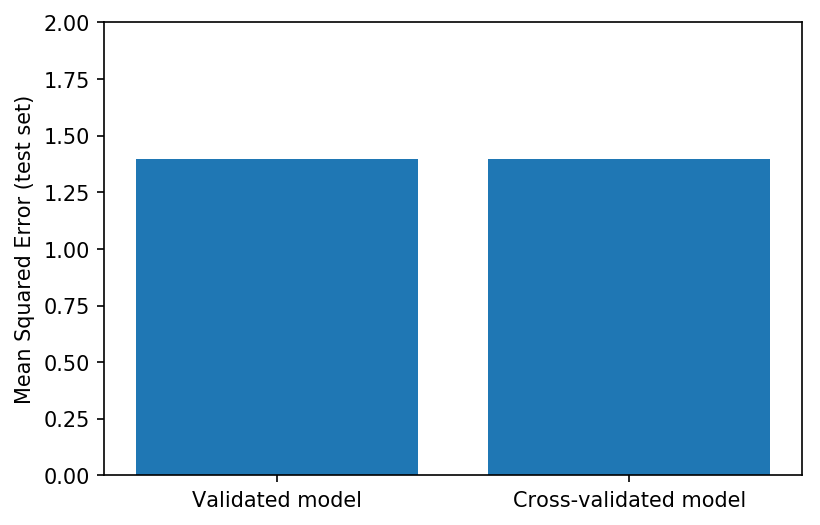

In [28]:
test_error5 = err 

print('High bias model:', test_error3)
print('Validated model:', test_error4)
print('Cross-validated model RMSE:', test_error5)

errors = ['Validated model', 'Cross-validated model']

fig=plt.figure(figsize=(6, 4), dpi= 150, facecolor='w', edgecolor='k')
plt.bar([1, 2],[ test_error4, test_error5], tick_label = errors)
plt.ylabel('Mean Squared Error (test set)'); plt.ylim([0, 2]);

## Regolarizzazione

In [29]:
r_alpha = (-10, 5) # regularization slider
def regularization(alpha=-10):
    alpha = 10**alpha # set regularization on a log scale
    degrees = range(30+1) # degree of polynomial
    d = 10 # chosen degree of the polynomial

    fig, col = plt.subplots(1, 2, figsize=(8, 4), dpi= 150, facecolor='w', edgecolor='k')

    X_train = train_dict[d] # dataset train
    X_train_scaled = scaler.fit_transform(X_train) 
    
    X_test = test_dict[d] # dataset test
    X_test_scaled = scaler.transform(X_test)
    
    ridge = Ridge(alpha=alpha) # Ridge regression model
    ridge.fit(X_train_scaled, y_train) # fit ridge model
    col[0].plot(x_train, f, 'k--',alpha=1, label='true function', linewidth=3)
    col[0].scatter(x_train, y_train, label="training", alpha=0.6, color='C0', s=30)
    col[0].scatter(x_test, y_test, label="testing", alpha=0.6, color='C8', s=15) 
    xx = np.arange(-6, 2, 0.01)
    X_plot = PolynomialFeatures(d).fit_transform(xx.reshape(-1,1))
    X_plot_scaled = scaler.transform(X_plot)
    col[0].plot(xx, ridge.predict(X_plot_scaled), '-', label="$\lambda$ = %s" % str(alpha), color='C3', linewidth=3)    
    col[0].text(-4, 8, "training score: $mse$ = {0:.2f}".format(mean_squared_error(y_train, ridge.predict(X_train_scaled))),
         color='C0')
    col[0].text(-4, 7.5, "test score: $mse$ = {0:.2f}".format(mean_squared_error(y_test, ridge.predict(X_test_scaled))), 
                color='C1')
    col[0].set_ylabel('y'); col[0].set_xlabel('x');  col[0].legend(loc='lower right')
    col[0].set_ylim(np.min(y_train)*0.9, np.max(y_train)*1.1); col[0].set_xlim((np.min(x_train), np.max(x_train)))
    
    coef = ridge.coef_.ravel()
    col[1].semilogy(np.abs(coef), marker='o', label="$\lambda$ = %s" % str(alpha))
    col[1].set_ylim([1e-5, 1e5]);  col[1].set_xlim([1, d])
    col[1].set_ylabel('abs(coefficient)'); col[1].set_xlabel('coefficients')
    col[1].legend(loc='upper left')
    col[1].set_xticks=(np.arange(d));
    
    
    plt.tight_layout()
    plt.show()
w = interactive(regularization, alpha=r_alpha)
w

interactive(children=(IntSlider(value=-10, description='alpha', max=5, min=-10), Output()), _dom_classes=('wid…

### Scelta del parametro $\lambda$ tramite cross-validazione

Max param grid: 1e-05
1.5459277364194786e-06


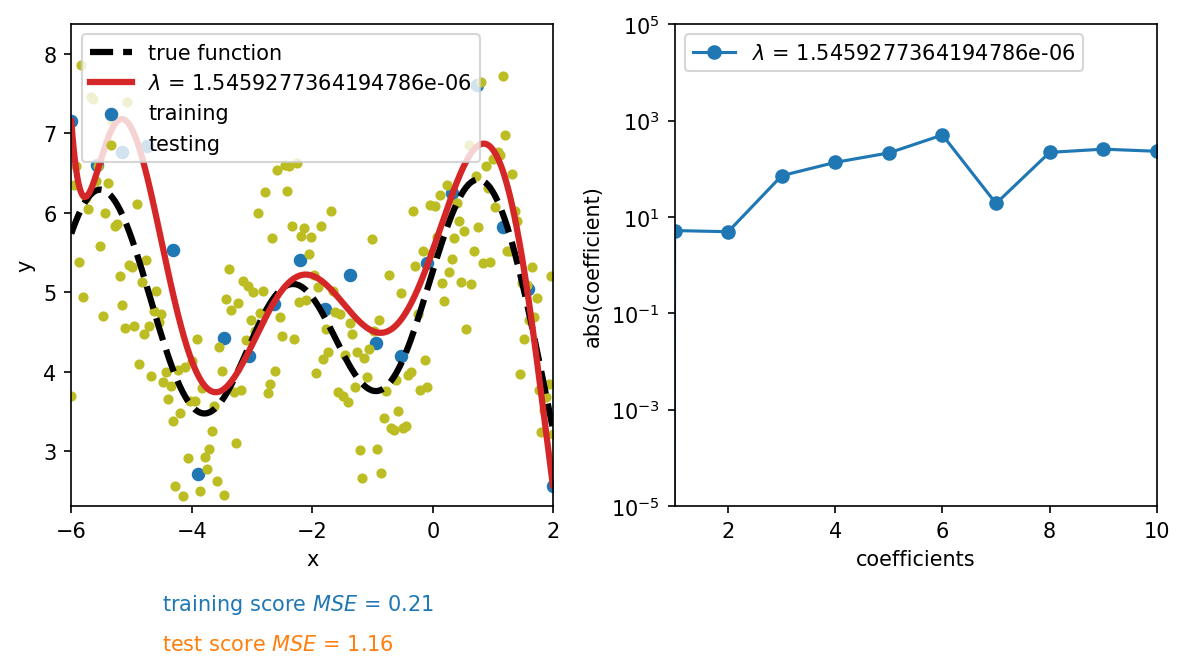

In [30]:
d = 10
param_grid = np.logspace(-7, -5, 1000)
print('Max param grid:' , np.max( param_grid) )

X_train = train_dict[d] # dataset train
X_train_scaled = scaler.fit_transform(X_train) 

X_test = test_dict[d] # dataset test
X_test_scaled = scaler.transform(X_test)

ridge = RidgeCV(alphas=param_grid)
ridge.fit(X_train_scaled, y_train)
alpha = ridge.alpha_
print(alpha)

fig, col = plt.subplots(1, 2, figsize=(8, 4), dpi= 150, facecolor='w', edgecolor='k')
test_error_reg = mean_squared_error(y_test, ridge.predict(X_test_scaled))
                                    
col[0].plot(x_plot, y_plot, 'k--', alpha=1, label='true function', linewidth=3)
col[0].scatter(x_train, y_train, label="training", s=30, color = 'C0')
col[0].scatter(x_test, y_test, label="testing", color='C8', s=15)
xx = np.arange(-6, 2, 0.01)
X_plot = PolynomialFeatures(d).fit_transform(xx.reshape(-1,1))
X_plot_scaled = scaler.transform(X_plot)
col[0].plot(xx, ridge.predict(X_plot_scaled),'-', label="$\lambda$ = %s" % str(alpha), color='C3', linewidth=3)
col[0].text(-4.5, 1, "training score $MSE$ = {0:.2f}".format(mean_squared_error(y_train, ridge.predict(X_train_scaled))),
     color='C0')
col[0].text(-4.5, 0.5, "test score $MSE$ = {0:.2f}".format(mean_squared_error(y_test, ridge.predict(X_test_scaled))), 
            color='C1')
col[0].set_ylabel('y'); col[0].set_xlabel('x')
col[0].legend(loc='upper left')
col[0].set_ylim([np.min(y_train)*0.9, np.max(y_train)*1.1]); col[0].set_xlim([np.min(x_train), np.max(x_train)])
coef = ridge.coef_.ravel()
col[1].semilogy(np.abs(coef), marker='o', label="$\lambda$ = %s" % str(alpha))
col[1].set_ylim([1e-5, 1e5]); col[1].set_xlim([1, d])
col[1].set_ylabel('abs(coefficient)'); col[1].set_xlabel('coefficients')
col[1].legend(loc='upper left')
col[1].set_xticks=(np.arange(d+1))
plt.tight_layout()
plt.show()

### Errore di test prima e dopo la regolarizzazione

Validated model RMSE: 1.3967063225610457
Cross validated model RMSE: 1.3967063225610457
Regularized model RMSE: 1.1639474758254404


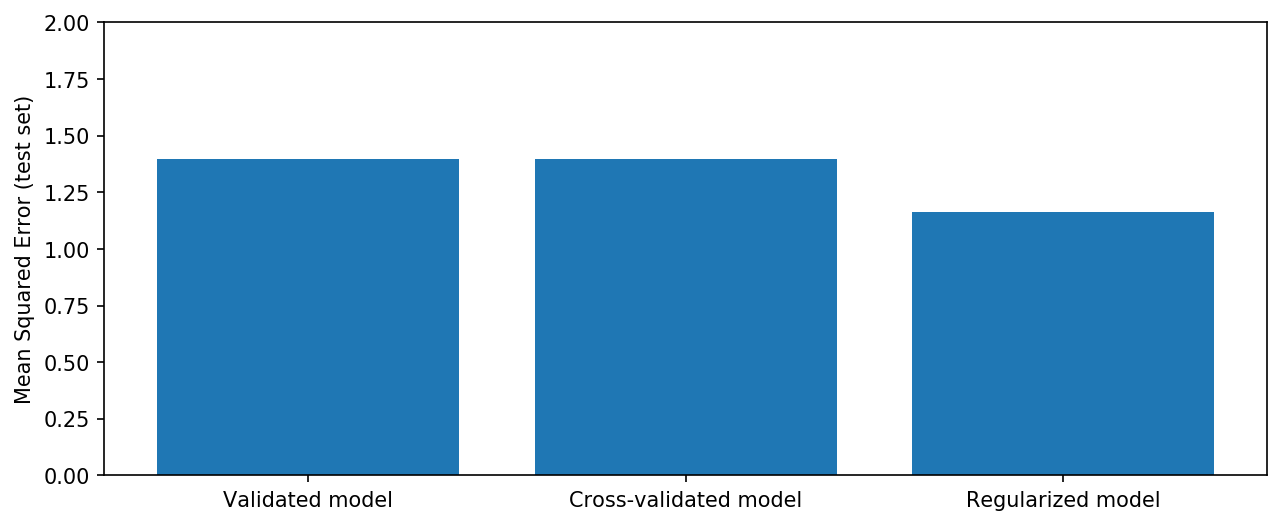

In [31]:
errors = ['Validated model', 'Cross-validated model', 'Regularized model']
fig=plt.figure(figsize=(10, 4), dpi= 150, facecolor='w', edgecolor='k')
plt.bar([1, 2, 3],[test_error4, test_error5, test_error_reg], tick_label = errors)
plt.ylabel('Mean Squared Error (test set)'); plt.ylim([0, 2])

print('Validated model RMSE:', test_error4)
print('Cross validated model RMSE:', test_error5)
print('Regularized model RMSE:', test_error_reg)

## Risorse

### Scikit-learn
Machine Learning in Python

Simple and efficient tools for data mining and data analysis
Accessible to everybody, and reusable in various contexts
Built on NumPy, SciPy, and matplotlib
Open source, commercially usable

 - http://scikit-learn.org/stable/auto_examples/index.html
 
 
 ### Tensorflow
 
 Deep learning framework by Google
 
 - https://www.tensorflow.org/tutorials/
   